# MNIST VERİ SETİ


    

MNIST, her biri 28 x 28 piksellik, 0 ila 255 piksel değerlerine sahip gri tonlamalı 70.000 elle yazılmış rakam görüntüsü içerir. Verileri kendimiz indirebilir ve önceden işleyebiliriz. Ancak scikit-learn'ün içinde yer alan veri setlerinde bizim istediğimiz mnist veri seti bulunmaktadır.
Bu yüzden bu veri setini sklearn kütüphanesinden indirmeye karar verdim. 

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
mnist_data = fetch_openml("mnist_784")

In [3]:
print(mnist_data.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


mnist veri setindeki target ve data keylerini alarak veri setini hazırlayalım.

In [4]:
X, y = mnist_data['data'], mnist_data['target']

print('Shape of X:', X.shape, 'Shape of y:', y.shape)

Shape of X: (70000, 784) Shape of y: (70000,)


In [5]:
# Gradyanlarımızı daha kolay tutmak için verileri normalleştireceğiz:

X = X / 255

In [6]:
 y.shape[0] 

70000

In [7]:
# one-hot encode labels
# Burada 10 x 70.000'lik bir dizi elde etmek için MNIST etiketlerini kodlayacağız

digits = 10  # veri setindeki farklı rakam adedi
examples = y.shape[0]  # 70000 örneklem sayımız mevcut

y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

print(Y_new)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# train ve test datası için gerekli splitleri yapalım
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]

In [9]:
print('Shape of X_train:', X_train.shape, 'Shape of Y_train:', Y_train.shape)

Shape of X_train: (784, 60000) Shape of Y_train: (10, 60000)


In [10]:
print('Shape of X_test:', X_test.shape, 'Shape of Y_test:', Y_test.shape)

Shape of X_test: (784, 10000) Shape of Y_test: (10, 10000)


In [11]:
# shuffle

shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [12]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
Y_train[:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

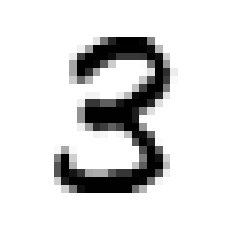

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [14]:
i = 101

plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
Y_train[:,i]

Çıktıda görüldüğü gibi arraydeki sırası 7.konumda bulunmaktadır

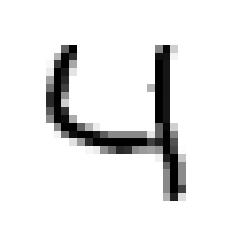

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [15]:
i = 302

plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
Y_train[:,i]

Çıktıda görüldüğü gibi arraydeki sırası 5.konumda bulunmaktadır

In [16]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s


# Cost Function Tanımlanması (Çoklu Sınıf İçin)


Maliyet fonksiyonumuz ikiden fazla sınıfa genellemek yaptığı için N sınıflı genel formülü aşağıda verilmiştir.

 $ L(y, \hat{y}) = -\sum_{i = 0}^n y_i \log(\hat{y}_i) $

$ L(Y, \hat{Y}) = - \frac{1}{m} \sum_{j = 0}^m \sum_{i = 0}^n y_i^{(j)} \log(\hat{y}_i^{(j)}) $

In [17]:
def compute_multiclass_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum
    
    return L


In [18]:
def feed_forward(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache


In [19]:
def back_propagate(X, Y, params, cache):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

In [20]:
np.random.seed(138)

# hyperparameters
n_x = X_train.shape[0]
n_h = 64
learning_rate = 4
beta = .9
batch_size = 128
batches = -(-m // batch_size)


In [21]:
# initialization


params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(1. / n_x),
           "W2": np.random.randn(digits, n_h) * np.sqrt(1. / n_h),
           "b2": np.zeros((digits, 1)) * np.sqrt(1. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)


In [22]:
V_dW1[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
V_db1[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [24]:
V_dW2[:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
V_db2[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [27]:
# train
# mini-batch gradient descent oluşturalım

for i in range(9):

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        feed = feed_forward(X, params)
        grads = back_propagate(X, Y, params, feed)

        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2

    feed = feed_forward(X_train, params)
    train_cost = compute_multiclass_loss(Y_train, feed["A2"])
    feed = feed_forward(X_test, params)
    test_cost = compute_multiclass_loss(Y_test, feed["A2"])
    print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("Done.")

Epoch 1: training cost = 0.10174268970240367, test cost = 0.11955876068494611
Epoch 2: training cost = 0.07859889330831527, test cost = 0.10582850450366496
Epoch 3: training cost = 0.061457215122181004, test cost = 0.09549396026058612
Epoch 4: training cost = 0.05139485914441815, test cost = 0.08925562832226555
Epoch 5: training cost = 0.050055535349367686, test cost = 0.09033835340539813
Epoch 6: training cost = 0.039432130677260174, test cost = 0.08484458161601327
Epoch 7: training cost = 0.03480206287011367, test cost = 0.0882855328896349
Epoch 8: training cost = 0.041661985767138726, test cost = 0.10423563507976565
Epoch 9: training cost = 0.02199897142568331, test cost = 0.08262176300615293
Done.


### MNIST İLE BINARY CLASSIFICATION OLUŞTURMAK İÇİN MODEL OLUŞTURALIM

Varsayılan MNIST etiketleri, yedi görüntüsü için 7'yi, dört görüntüsü için 4'ü vb. olarak kaydeder. Ancak şimdilik sadece bir sıfır sınıflandırıcı oluşturalım. Bu yüzden etiketlerimizin sıfır olduğunda 1, aksi takdirde 0 demesini istiyoruz . Bu nedenle, bunun gerçekleşmesi için etiketlerin üzerine yazacağız ve ona uygun cost function oluşturacağız.

In [28]:
X, y = mnist_data['data'], mnist_data['target']
print('Shape of X:', X.shape,'\n', 'Shape of y:', y.shape)

Shape of X: (70000, 784) 
 Shape of y: (70000,)


In [29]:
# Gradyanlarımızı yönetilebilir tutmak için verileri normalleştireceğiz:

X = X / 255

In [30]:
y_new = np.zeros(y.shape)
y_new[np.where(y == 0.0)[0]] = 1
y = y_new

In [31]:
m = 60000
m_test = X.shape[0] - m

In [32]:
X_train, X_test = X[:m].T, X[m:].T

In [33]:
X_train.shape, X_test.shape

((784, 60000), (784, 10000))

In [34]:
y_train, y_test = y[:m].reshape(1,m), y[m:].reshape(1,m_test)

In [35]:
y_train.shape, y_test.shape

((1, 60000), (1, 10000))

In [36]:
np.random.seed(100)
shuffle_index = np.random.permutation(m)
shuffle_index

array([34046,  2951,  5692, ..., 14147, 56088, 38408])

In [37]:
X_train, y_train = X_train[:,shuffle_index], y_train[:,shuffle_index]

Şimdi eğitim setinde oluşturduğumuz rastgele bir resme ve etiketine bir göz atalım:

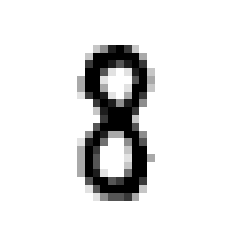

[0.]


In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

i = 7
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(y_train[:,i])

Çıktıdaki sayının 8 olduğu gözükmektedir.Bu nedenle etiketin 0 olması istediğimiz bir durumdur. Çünkü çıktısı 0 hariç tüm rakamlardaki etiketin 0 olmasını bekliyoruz.

##### Forward Propogation


Sigmoid fonksiyonunu oluşturalım

$ \hat{y} = \sigma(w^T x + b) $

$ \sigma(z) = \frac{1}{1 + e^{-z}} $

In [39]:

def sigmoid(z):
    
    result = 1 / (1 + np.exp(-z))
    
    return result

## Cost Function Tanımlayalım (İkili Sınıflandırma İçin)

Maliyet fonksiyonumuz için çapraz entropi kullanacağız. Tek bir eğitim örneğinin formülü aşağıdaki gibidir:

$L(y, \hat{y}) = -y \log(\hat{y}) - (1-y) \log(1-\hat{y})$


Bir eğitim setindeki tüm  örneklerin ortalamasını alırsak aşağıdaki ifadeyi elde ederiz.

$L(Y, \hat{Y}) = -\frac{1}{m} \sum_{i=1}^m \left( y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)}) \right)$

compute_loss fonksiyonunu oluşturalım.

In [40]:
def compute_loss(Y, Y_hat):
    
    m = Y.shape[1]
    L = -(1/m) * (np.sum (np.multiply(np.log(Y_hat),Y)) + np.sum( np.multiply(np.log(1-Y_hat),(1-Y))))
    
    return L

### Backward Propagation

 \begin{align}
  z &= w^T x + b,\newline
  \hat{y} &= \sigma(z),\newline
  L(y, \hat{y}) &= -y \log(\hat{y}) - (1-y) \log(1-\hat{y}).
  \end{align}
  
  
Geri yayılım için, L'nin w'nin her bir bileşeni wj'ye göre nasıl değiştiğini bilmemiz gerekmktedir.

#### Build & Train

In [41]:
learning_rate = 1

X = X_train
Y = y_train

n_x = X.shape[0] # 70 000 örneklem
m = X.shape[1]  # 784 feature 

W = np.random.randn(n_x, 1) * 0.01
b = np.zeros((1, 1))

for i in range(2000):
    
    Z = np.matmul(W.T, X) + b
    Y_head = sigmoid(Z)

    cost = compute_loss(Y, Y_head)

    dW = (1/m) * np.matmul(X, (Y_head-Y).T)
    db = (1/m) * np.sum(Y_head-Y, axis=1, keepdims=True)

    W = W - learning_rate * dW
    b = b - learning_rate * db

    if (i % 200 == 0):
        print("Epoch", i, "cost: ", cost)

print("Final cost:", cost)

Epoch 0 cost:  0.7115346719448323
Epoch 200 cost:  1.2982816577870062e-05
Epoch 400 cost:  1.265735571255418e-05
Epoch 600 cost:  1.234903310001593e-05
Epoch 800 cost:  1.2056494428385626e-05
Epoch 1000 cost:  1.1778526201107384e-05
Epoch 1200 cost:  1.1514037769655972e-05
Epoch 1400 cost:  1.1262046061045431e-05
Epoch 1600 cost:  1.1021662538679437e-05
Epoch 1800 cost:  1.0792082023433848e-05
Final cost: 1.0573646690375663e-05


# ŞİMDİ MNIST VERİ SETİNİ İLE PYTORCH KÜTÜPHANESİNDEN FAYDALANARAK MODEL OLUŞTURALIM

In [49]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import os
from torch import optim
import math
from torchvision import datasets 

In [50]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [51]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])


In [52]:
batch_size = 150
valid_size = 0.2

In [53]:

trainset = datasets.MNIST('.', download=False, train=True, transform=transform)
testset = datasets.MNIST('.', download=False, train=False, transform=transform)


In [54]:

# Training  Validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [55]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [56]:

batch_size = 150
valid_size = 0.2

In [57]:
# DataLoaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)


In [58]:
batch_count = len(trainloader)
print('(Training data):', len(train_idx))
print('(Validation data):', len(valid_idx))
print('(Test data):', len(testset))
print('Batch :', batch_count)

(Training data): 48000
(Validation data): 12000
(Test data): 10000
Batch : 320


In [59]:
def get_accuracy(predicted, target):
    equals = predicted.max(1)[1] == target
    return torch.mean(equals.type(torch.FloatTensor)).item()

In [60]:
def train(model, criterion, optimizer, epoch, save_file_name='model.pt'):
    train_losses, valid_losses = [], []
    
    valid_loss_min = np.Inf

    for e in range(epoch):
        batch_n = 1
        batch_mean_loss = 0
        batch_mean_accuracy = 0
        print(f'Epoch: {e+1}/{epoch}')

        for images, labels in trainloader:
            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            batch_mean_loss += loss.item()
            batch_mean_accuracy += get_accuracy(log_ps, labels)

            batch_n += 1
        else:
            valid_loss = 0
            valid_accuracy = 0
            with torch.no_grad():
                model.eval()
                for images, labels in validloader:
                    log_ps = model(images)
                    valid_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    valid_accuracy += get_accuracy(ps, labels)
            model.train()
            
            valid_loss /= len(validloader)
            valid_accuracy /= len(validloader)
            
            train_losses.append(batch_mean_loss/len(trainloader))
            valid_losses.append(valid_loss)

            print("Training Loss: {:.3f}|| ".format(batch_mean_loss/len(trainloader)),
                  "Validation Loss: {:.3f}||".format(valid_loss),
                  "Validation Accuracy: {:.3f}%".format(valid_accuracy*100))
            
            if valid_loss_min > valid_loss:
                print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...\n'.format(valid_loss_min,valid_loss))
                torch.save(model.state_dict(), save_file_name)
                valid_loss_min = valid_loss
    return model, train_losses, valid_losses

In [61]:
def test(model):
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            test_accuracy += get_accuracy(ps, labels)
    model.train()

    test_loss /= len(testloader)
    test_accuracy /= len(testloader)
    return test_accuracy, test_loss

In [62]:
input_size = 784
hidden_size = 160
output_size = 10

In [63]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [64]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [66]:
save_name = 'model.pt'
model, train_losses, valid_losses = train(model, criterion, optimizer, epoch=10, save_file_name=save_name)

Epoch: 1/10
Training Loss: 0.164||  Validation Loss: 0.133|| Validation Accuracy: 96.025%
	Validation loss decreased (inf --> 0.132786).  Saving model ...

Epoch: 2/10
Training Loss: 0.112||  Validation Loss: 0.100|| Validation Accuracy: 96.967%
	Validation loss decreased (0.132786 --> 0.100182).  Saving model ...

Epoch: 3/10
Training Loss: 0.085||  Validation Loss: 0.092|| Validation Accuracy: 97.242%
	Validation loss decreased (0.100182 --> 0.091555).  Saving model ...

Epoch: 4/10
Training Loss: 0.066||  Validation Loss: 0.088|| Validation Accuracy: 97.292%
	Validation loss decreased (0.091555 --> 0.088467).  Saving model ...

Epoch: 5/10
Training Loss: 0.054||  Validation Loss: 0.080|| Validation Accuracy: 97.583%
	Validation loss decreased (0.088467 --> 0.080311).  Saving model ...

Epoch: 6/10
Training Loss: 0.043||  Validation Loss: 0.077|| Validation Accuracy: 97.558%
	Validation loss decreased (0.080311 --> 0.077146).  Saving model ...

Epoch: 7/10
Training Loss: 0.038||  Val